# Model Initiation

In [814]:
#Libary
import pandas as pd
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [815]:
import ixmp

mp = ixmp.Platform()

In [816]:
#convert mtoe to GWa
conv_mtoe_gwa = 11.63*1000/8760
conv_twh_gwa = 1000/8760

In [817]:
import message_ix

scenario = message_ix.Scenario(
    mp, model='Indonesia Prototype', scenario='baseline', version='new'
)

# Functions

In [818]:
import math

def get_act_vtg_years(y_df, horizon, lifetimes, technology, period_step=5):
    """
    Get active years and vintage years according to technology lifetime,
    adjusted for data with step intervals (e.g., 5-year periods)
    """
    lifetime_periods = int(lifetimes[technology] // period_step)  # How many 5-year steps fit in the lifetime

    for year in horizon:
        count = y_df[y_df['year_vtg'] == year]['year_vtg'].value_counts()
        if year in count and count[year] > lifetime_periods:
            df = y_df[y_df['year_vtg'] == year]
            excess = count[year] - lifetime_periods
            index_to_remove = df.index[-excess:]  # remove the last rows beyond lifetime
            y_df = y_df.drop(index=index_to_remove)

    return y_df['year_vtg'], y_df['year_act']


In [819]:
def fix_negative_values(df, fuel_col='fuel', year_col='Year', value_col='value'):
    """
    Fix negative values by transferring values within the same fuel type.
    Priority: Add to next year if exists, otherwise pull from previous years.
    
    Parameters:
    - df: pandas DataFrame
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Adjusted DataFrame
    """
    # Sort first to ensure correct order
    df = df.sort_values(by=[fuel_col, year_col]).reset_index(drop=True)
    
    # Iterate through DataFrame
    i = 0
    while i < len(df):
        if df.loc[i, value_col] < 0:
            current_fuel = df.loc[i, fuel_col]
            
            # Try to find next year with same fuel
            next_indices = df.index[(df.index > i) & (df[fuel_col] == current_fuel)]
            
            if len(next_indices) > 0:
                next_i = next_indices[0]
                df.loc[next_i, value_col] += df.loc[i, value_col]
                df.loc[i, value_col] = 0
            else:
                # No next year: pull from previous years
                prev_indices = df.index[(df.index < i) & (df[fuel_col] == current_fuel)].tolist()
                prev_indices = prev_indices[::-1]  # Closest previous first

                for prev_i in prev_indices:
                    df.loc[i, value_col] += df.loc[prev_i, value_col]
                    df.loc[prev_i, value_col] = 0
                    if df.loc[i, value_col] >= 0:
                        break
        i += 1
    
    return df


In [820]:
def fill_missing_values(main_df, reference_df, fuel_col='fuel', year_col='Year', value_col='value', year=2005,year_step=1):
    """
    Fill missing or zero values in main_df using reference_df.

    Parameters:
    - main_df: DataFrame that needs filling
    - reference_df: DataFrame providing reference values
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Filled DataFrame
    """
    df = main_df.copy()
    
    for idx, row in df.iterrows():
        # If value is NaN or zero
        if pd.isna(row[value_col]):
            ref_value = reference_df.loc[
                (reference_df[fuel_col] == row[fuel_col]) & (reference_df[year_col] == year),
                value_col
            ]
            if not ref_value.empty:
                df.at[idx, value_col] = ref_value.values[0]/year_step
    
    return df

# Model Structure

<img src='Messageix Indonesia Structure.drawio.png' width='1000'>

In [821]:
#Horizon

historical_horizon = list(range(2005,2021,5))
model_horizon = list(range(2025,2071,5))

horizon = historical_horizon+model_horizon

scenario.add_horizon(year=historical_horizon+model_horizon,firstmodelyear=2025)

In [822]:
#Node Location

country='IDN'
scenario.add_spatial_sets({'country':country})

In [823]:
#Commodities

demand_com = [
    'industry_el',
    'transport_el',
    'commercial_el',
    'residential_el'
]

commodities = [
    'coal',
    'electricity',
    'gas',
    'oil',
    'biomass'
]

all_com = demand_com + commodities

In [824]:
#technology

ppl_tec = [
    'coal_ppl',
    'gas_ppl',
    'oil_ppl',
    'hydro_ppl',
    'solar_ppl',
    'onshorewind_ppl',
    'offshorewind_ppl',
    'geo_ppl',
    'bio_ppl',
    'nuclear_ppl'
]

t_d_tec = [
    'electricity_grid'
           ]

demand_tec = [
    'industry_el_tec',
    'transport_el_tec',
    'commercial_el_tec',
    'residential_el_tec'
]

all_tec =  ppl_tec + t_d_tec + demand_tec

In [825]:
scenario.add_set('commodity',all_com)
scenario.add_set('level',['primary','secondary','final','useful'])
scenario.add_set('technology',all_tec)
scenario.add_set('mode','standard')
scenario.add_set('level_resource','primary')
scenario.add_set('grade',['a_coal','a_gas','a_oil','a_biomass'])

In [826]:
#Add sets for renewables
scenario.add_set('level',['renewable'])
scenario.add_set('commodity',['solar_energy','wind_onshore','wind_offshore'])
scenario.add_set('level_renewable',['renewable'])

In [827]:
#Define new technology category for renewables
scenario.add_set('type_tec',['renewable'])
df = pd.DataFrame({'type_tec':['renewable','renewable','renewable'],'technology':['solar_ppl','onshorewind_ppl','offshorewind_ppl']})
scenario.add_set('cat_tec',df)

## Demand Parameter

In [828]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)

sectors = ['Industry','Transport','Commercial','Residential']
sector_models = ['industry_el','transport_el','commercial_el','residential_el']

In [829]:
for sector,sector_model in zip(sectors,sector_models):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,5)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2020)]
    df.value = df.value*conv_mtoe_gwa
    coeffs = np.polyfit(df["Year"].values.astype(int), df["value"].values.astype(float), deg=1)
    poly = np.poly1d(coeffs)

    # Predict values for the missing years
    future_years = list(range(2055,2071,5))
    predicted_values = poly(future_years)
    newrow = pd.DataFrame({'Year':list(range(2055,2071,5)),'Fuel':['Electricity' for _ in range(4)], 'value':predicted_values})
    df = pd.concat([df,newrow])
    values = df.value.tolist()

    df_demand = pd.DataFrame(
        {
            'node':country,
            'commodity':f'{sector_model}',
            'level':'useful',
            'year': model_horizon,
            'time':'year',
            'value':values,
            'unit':'GWa'
        }
    )

    scenario.add_par('demand',df_demand)
    

## Engineering Parameters

### Input

In [830]:
year_df = scenario.vintage_and_active_years(in_horizon=False)
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]

In [831]:
#Technical Lifetime (data from LEAP)
from message_ix import make_df

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg':vintage_years,
    'unit':'y'
}

lifetimes ={
    'coal_ppl':40,
    'gas_ppl':30,
    'oil_ppl':40,
    'hydro_ppl':40,
    'solar_ppl':20,
    'onshorewind_ppl':20,
    'offshorewind_ppl':20,
    'geo_ppl':30,
    'bio_ppl':30,
    'nuclear_ppl':60
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime,technology=tec,value=val)
    scenario.add_par('technical_lifetime',df)

In [832]:
#Data from LEAP
coal_ppl_eff = 0.37 
gas_ppl_eff = 0.33 
oil_ppl_eff = 0.45 
bio_ppl_eff = 0.34

In [833]:
#Coal Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
base_coal_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"coal",
    "time":"year",
    "time_origin":"year"
}

coal_ppl = pd.DataFrame(
    dict(
        technology='coal_ppl',
        level='primary',
        value=1/coal_ppl_eff,
        unit='-',
        **base_coal_input,
    )
)

#Gas Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
base_gas_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"gas",
    "time":"year",
    "time_origin":"year"
}

gas_ppl = pd.DataFrame(
    dict(
        technology='gas_ppl',
        level='primary',
        value=1/gas_ppl_eff,
        unit='-',
        **base_gas_input,
    )
)

#Oil Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
base_oil_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"oil",
    "time":"year",
    "time_origin":"year"
}

oil_ppl = pd.DataFrame(
    dict(
        technology='oil_ppl',
        level='primary',
        value=1/oil_ppl_eff,
        unit='-',
        **base_oil_input,
    )
)

#Biomass Input
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'bio_ppl')
base_bio_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"biomass",
    "time":"year",
    "time_origin":"year"
}

bio_ppl = pd.DataFrame(
    dict(
        technology='bio_ppl',
        level='primary',
        value=1/bio_ppl_eff,
        unit='-',
        **base_bio_input,
    )
)


scenario.add_par("input",coal_ppl)
scenario.add_par("input",gas_ppl)
scenario.add_par("input",oil_ppl)
scenario.add_par("input",bio_ppl)

In [834]:

#Electricity Input
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
base_electr_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"electricity",
    "time":"year",
    "time_origin":"year"
}
historical_grid_eff = [1.225103251,1.180351516,1.186777289,1.134548094]
grid_eff = 1.18081555 #Average of the historical efficiency

electr_grid = make_df(
    base_electr_input,
    technology='electricity_grid',
    level='secondary',
    value=historical_grid_eff + [grid_eff]*len(range(2025,2071,5)),
    unit='-',
)

scenario.add_par("input",electr_grid)

for tec in demand_tec:
    electr_in = make_df(
        base_electr_input,
        technology = f'{tec}',
        level = 'final',
        value=1,
        unit ='-'
    )
    scenario.add_par('input',electr_in)
    



### VRE Input and Potential

In [835]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'IDN_Solar_wind.xlsx'
filename = os.path.join(path,filename)

df_solar = pd.read_excel(filename,sheet_name='Bins')[:17]
df_solar.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_solar = df_solar[df_solar['grade'].str.contains('solar')]
df_solar = pd.melt(df_solar,id_vars='grade',value_vars=list(range(2005,2071,5)),var_name='Year')

In [836]:
#RE solar input (Potential)

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'solar_ppl')

df = pd.DataFrame(
    {
        "node_loc": country,
        "technology": "solar_ppl",
        "year_vtg": vintage_years,
        "year_act": act_years,
        "mode": "standard",
        "node_origin": country,
        "commodity": "solar_energy",
        "level": "renewable",
        "time": "year",
        "time_origin": "year",
        "value": 1,
        "unit": "%",
    }
)

scenario.add_par("input", df)

grades = [f'solar_res{i+1}' for i in range(8)]

scenario.add_set('grade',grades)

#Historical Values

idx = pd.MultiIndex.from_product(
    [[country],['solar_energy'],grades,['renewable'],historical_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_solar[df_solar['Year']<2021]['value'].unique().tolist()

df =pd.DataFrame({
    'value':values*len(historical_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

#Model Values
idx = pd.MultiIndex.from_product(
    [[country],['solar_energy'],grades,['renewable'],model_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_solar[df_solar['Year']>2020]['value'].unique().tolist()

df =pd.DataFrame({
    'value':values*len(model_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

In [837]:
#RE onshorewind input (Potential)
df_wind = pd.read_excel(filename,sheet_name='Bins')[:17]
df_wind.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_wind = df_wind[df_wind['grade'].str.contains('wind_res')]
df_wind = pd.melt(df_wind,id_vars='grade',value_vars=list(range(2005,2071,5)),var_name='Year')
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'onshorewind_ppl')

df = pd.DataFrame(
    {
        "node_loc": country,
        "technology": "onshorewind_ppl",
        "year_vtg": vintage_years,
        "year_act": act_years,
        "mode": "standard",
        "node_origin": country,
        "commodity": "wind_onshore",
        "level": "renewable",
        "time": "year",
        "time_origin": "year",
        "value": 1,
        "unit": "%",
    }
)

scenario.add_par("input", df)

grades = [f'wind_res{i+1}' for i in range(4)]

scenario.add_set('grade',grades)

#Historical Values

idx = pd.MultiIndex.from_product(
    [[country],['wind_onshore'],grades,['renewable'],historical_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_wind[df_wind['Year']<2021]['value'].unique().tolist()
values.insert(0,0.0)

df =pd.DataFrame({
    'value':values*len(historical_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

#Model Values
idx = pd.MultiIndex.from_product(
    [[country],['wind_onshore'],grades,['renewable'],model_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_wind[df_wind['Year']>2020]['value'].unique().tolist()
values.insert(0,0.0)


df =pd.DataFrame({
    'value':values*len(model_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

In [838]:
#RE offshorewind input (Potential)
df_wind = pd.read_excel(filename,sheet_name='Bins')[:17]
df_wind.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_wind = df_wind[df_wind['grade'].str.contains('wind_ref')]
df_wind = pd.melt(df_wind,id_vars='grade',value_vars=list(range(2005,2071,5)),var_name='Year')
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'onshorewind_ppl')

df = pd.DataFrame(
    {
        "node_loc": country,
        "technology": "offshorewind_ppl",
        "year_vtg": vintage_years,
        "year_act": act_years,
        "mode": "standard",
        "node_origin": country,
        "commodity": "wind_offshore",
        "level": "renewable",
        "time": "year",
        "time_origin": "year",
        "value": 1,
        "unit": "%",
    }
)

scenario.add_par("input", df)

grades = [f'wind_ref{i+1}' for i in range(5)]

scenario.add_set('grade',grades)

#Historical Values

idx = pd.MultiIndex.from_product(
    [[country],['wind_offshore'],grades,['renewable'],historical_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_wind[df_wind['Year']<2021]['value'].unique().tolist()
values.insert(0,0.0)

df =pd.DataFrame({
    'value':values*len(historical_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

#Model Values
idx = pd.MultiIndex.from_product(
    [[country],['wind_offshore'],grades,['renewable'],model_horizon,['GWa']],
    names = ['node','commodity','grade','level','year','unit'],
)

values = df_wind[df_wind['Year']>2020]['value'].unique().tolist()
values.insert(0,0.0)


df =pd.DataFrame({
    'value':values*len(model_horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_potential',df)

### Output

In [839]:
#Output
base_output = {
'node_loc':country,
'mode':'standard',
'node_dest':country,
'time':'year',
'time_dest':'year',   
}



#coal_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
coal_ppl = make_df(
    base_output,
    technology ='coal_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'
    
)

#gas_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
gas_ppl = make_df(
    base_output,
    technology ='gas_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#oil_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
oil_ppl = make_df(
    base_output,
    technology ='oil_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#hydro_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'hydro_ppl')
hydro_ppl = make_df(
    base_output,
    technology ='hydro_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#solar_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'solar_ppl')
solar_ppl = make_df(
    base_output,
    technology ='solar_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#onshorewind_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'onshorewind_ppl')
onshorewind_ppl = make_df(
    base_output,
    technology ='onshorewind_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#offshorewind_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'offshorewind_ppl')
offshorewind_ppl = make_df(
    base_output,
    technology ='offshorewind_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#geo_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'geo_ppl')
geo_ppl = make_df(
    base_output,
    technology ='geo_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#bio_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'bio_ppl')
bio_ppl = make_df(
    base_output,
    technology ='bio_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#nuclear_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'nuclear_ppl')
nuclear_ppl = make_df(
    base_output,
    technology ='nuclear_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)


#electricity grid
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
electr_grid = make_df(
    base_output,
    technology ='electricity_grid',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'final',
    value = 1, 
    unit = '-'
)

for tec in ppl_tec:
    df = globals()[f'{tec}']
    scenario.add_par('output',df)
    
scenario.add_par("output",electr_grid)

for tec,com in zip(demand_tec,demand_com):
    electr_out = make_df(
        base_output,
        technology = f'{tec}',
        commodity = f'{com}',
        year_vtg = vintage_years,
        year_act = act_years,
        level = 'useful',
        value=1,
        unit ='-'
    )
    scenario.add_par('output',electr_out)

### Capacity Factor

#### VRE CF

In [840]:
#RE solar input (Capacity Factor)

grades = [f'solar_res{i+1}' for i in range(8)]

df_solar = pd.read_excel(filename,sheet_name='Renewable_CF')
df_solar.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_solar = df_solar[df_solar['grade'].str.contains('solar')]
df_solar = pd.melt(df_solar,id_vars='grade',value_vars='CF',var_name='Year')


idx = pd.MultiIndex.from_product(
    [[country],['solar_energy'],grades,['renewable'],horizon,['-']],
    names = ['node','commodity','grade','level','year','unit'],
)
values = df_solar['value'].tolist()

df = pd.DataFrame({
    'value':values*len(horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_capacity_factor',df)

In [841]:
#RE onshore wind input (Capacity Factor)
grades = [f'wind_res{i+1}' for i in range(4)]

df_wind = pd.read_excel(filename,sheet_name='Renewable_CF')[:17]
df_wind.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_wind = df_wind[df_wind['grade'].str.contains('wind_res')]
df_wind = pd.melt(df_wind,id_vars='grade',value_vars='CF',var_name='Year')


idx = pd.MultiIndex.from_product(
    [[country],['wind_onshore'],grades,['renewable'],horizon,['-']],
    names = ['node','commodity','grade','level','year','unit'],
)
values = df_wind['value'].tolist()

df = pd.DataFrame({
    'value':values*len(horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_capacity_factor',df)

In [842]:
#RE offshore wind input (Capacity Factor)
grades = [f'wind_ref{i+1}' for i in range(5)]


df_wind = pd.read_excel(filename,sheet_name='Renewable_CF')[:17]
df_wind.rename(columns={'Unnamed: 0':'grade'},inplace=True)
df_wind = df_wind[df_wind['grade'].str.contains('wind_ref')]
df_wind = pd.melt(df_wind,id_vars='grade',value_vars='CF',var_name='Year')


idx = pd.MultiIndex.from_product(
    [[country],['wind_offshore'],grades,['renewable'],horizon,['-']],
    names = ['node','commodity','grade','level','year','unit'],
)
values = df_wind['value'].tolist()

df = pd.DataFrame({
    'value':values*len(horizon)
},idx.sortlevel('year')[0]).reset_index()

df = df.sort_values('grade').reset_index()

scenario.add_par('renewable_capacity_factor',df)

#### Conventional Technology Capacity Factor

In [843]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)


ppl_tec_nonre = ['coal_ppl',
 'gas_ppl',
 'oil_ppl',
 'hydro_ppl',
 'geo_ppl',
 'bio_ppl',
 'nuclear_ppl']
ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Geothermal','Bioenergy','Nuclear']

df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')
df_cap = df_cap[df_cap['fuel']!='Energy Storage']

df_cf = df_gen.merge(df_cap,on=['fuel','Year'],how='outer',suffixes=('_gen','_cap'))
df_cf['cf'] = (df_cf['value_gen']*1000/8760)/df_cf['value_cap']
df_cf['cf'].fillna(0,inplace=True)

base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

capacity_factor ={
    'coal_ppl':0.8, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'gas_ppl':0.85, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'oil_ppl':0.95, # for Fuel Oil and Diesel Power Plant, Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'hydro_ppl':0.492, #Last Historical Year Value from LEAP AEO8 Calculation in 2020
    'solar_ppl':0.186, #Last Historical Year Value from LEAP AEO8 Calculation in 2022
    'wind_ppl':0.44, #Placeholder from NREL ATB 2023 - average for all wind classes (moderate)
    'geo_ppl':0.9, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'bio_ppl':0.8, #Handayani et al. (2022) based on RUPTL 2021-2030, IEA-NEA, Mongird et al (2019)
    'nuclear_ppl':0.95 #LWR Nuclear BWRX -300 https://aris.iaea.org/PDF/BWRX-300_2020.pdf
}

for com,tec in zip(ppl_commodities,ppl_tec_nonre):


    vintage_years, active_years = get_act_vtg_years(year_df, horizon, lifetimes, tec)
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(active_years)})

    df_cf_tec = df_cf[df_cf['fuel'] == com].dropna(subset=['cf'])
    full_cf = va_year_df.merge(df_cf_tec,left_on='vintage_years',right_on='Year',how='left')

    full_cf['cf'].fillna(capacity_factor[tec],inplace=True)

    df = make_df(
            base_capacity_factor,
            technology=tec,
            year_vtg=full_cf['vintage_years'].tolist(),
            year_act=full_cf['active_years'].tolist(),
            value=full_cf['cf'].tolist()
        )
    df.dropna(inplace=True)
    df.year_vtg = df.year_vtg.astype(int)

        # Step 8: Add to scenario
    scenario.add_par('capacity_factor', df)


In [844]:
#solar and wind capacity technology conventional capacity factor

path = os.getcwd()
path = os.path.dirname(path)
filename = 'IDN_Solar_wind.xlsx'
filename = os.path.join(path,filename)

for tec in ['solar_ppl','onshorewind_ppl','offshorewind_ppl']:


    df = pd.read_excel(filename,sheet_name='New_act_cap_5yr')
    df = df[df['technology'] == tec]
    df = pd.melt(df,id_vars=['node_loc','Metric'],value_vars=[2005,2010,2015,2020],var_name='Year')
    df = df[df['Metric'] == 'CF']

    vintage_years,act_years = get_act_vtg_years(year_df, horizon, lifetimes,'solar_ppl')
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(act_years)})

    df_cf = va_year_df.merge(df[['Year','Metric','value']],left_on='active_years',right_on='Year',how='left')
    df_cf['value'].fillna(1,inplace=True)

    df_cf.drop(columns=['Year','Metric'],inplace=True)

    df = make_df(
            base_capacity_factor,
            technology=tec,
            year_vtg=df_cf['vintage_years'].tolist(),
            year_act=df_cf['active_years'].tolist(),
            value=df_cf['value'].tolist()
        )
    df.dropna(inplace=True)
    df.year_vtg = df.year_vtg.astype(int)

        # Step 8: Add to scenario
    scenario.add_par('capacity_factor', df)




## Technoeconomic Parameters

### Resource Parametrisation

In [845]:
#Resource cost in USD 2020/MWh

path = os.getcwd()
path = os.path.dirname(path)
filename = 'LEAP_Indonesia_data.xlsx'
filename = os.path.join(path,filename)

df_cost = pd.read_excel(filename,sheet_name='resource_cost')
df_cost.rename(columns={'Branch':'technology'},inplace=True)
df_cost = pd.melt(df_cost,id_vars='technology',value_vars=list(range(2005,2071,5)),var_name='Year')

#convert cost from USD/MWh to USD/Kwa
df_cost['value'] = df_cost['value']*8.76

In [846]:
#Resource parameters

'''Data Format
Reserves Volume (GWa)|Historical Extraction (GWa)
'''
#Coal Energy Content 18.8 GJ/Ton
coal_reserves = 34868968.53*1000 #Tonnes Data as of December 31 2021 from US EIA
coal_reserves_gwa = coal_reserves*18.8*277.78/8760*1e-6 

coal_extraction = 563728255 #Ton, Handbook of Energy and Economic Statistics of Indonesia (HEESI) 2020
coal_extraction_gwa = coal_extraction*18.8*277.78/8760*1e-6

coal_potentials = {'a':[coal_reserves_gwa,coal_extraction_gwa]} 

#Natural gas energy content 34.2 MJ/m3, 1 SCF = 1037 BTU
gas_reserves = 1.77*1e12 #m3
gas_reserves_gwa = gas_reserves*34.2*277.78/8760*1e-9

gas_extraction = 2442831 #MMSCF, HEESI 2020
gas_extraction_gwa = gas_extraction*1.037*1e9*0.0002931/(8760*1e6)

gas_potentials = {'a':[gas_reserves_gwa,gas_extraction]}

#Fuel Oil Energy content 40.19 GJ/Ton, 1 BOE = 5.815 GJ
oil_reserves = 4.17*1e9 #BOE
oil_reserves_gwa = oil_reserves*5.815*277.78/(8760*1e6)

oil_extraction = 259247*1e3 #BBL
oil_extraction_gwa = oil_extraction*5.815*277.78/(8760*1e6)

oil_potentials = {'a':[oil_reserves_gwa,oil_extraction_gwa]}

bio_potentials = {'a':[2445,1.425]}  #Need to update data

In [847]:
'''#Resource parameters

Data Format
Reserves Volume (GWa)|Cost (USD/Kwa) |Historical Extraction (GWa)

#Coal Energy Content 18.8 GJ/Ton
coal_reserves = 34868968.53*1000 #Tonnes Data as of December 31 2021 from US EIA
coal_reserves_gwa = coal_reserves*18.8*277.78/8760*1e-6 

coal_cost = 59.04 #USD 2020 per Metric Ton
coal_cost_kwa = coal_cost/(18.8*277.78)*8760

coal_extraction = 563728255 #Ton, Handbook of Energy and Economic Statistics of Indonesia (HEESI) 2020
coal_extraction_gwa = coal_extraction*18.8*277.78/8760*1e-6

coal_potentials = {'a':[coal_reserves_gwa,coal_cost_kwa,coal_extraction_gwa]} 

#Natural gas energy content 34.2 MJ/m3, 1 SCF = 1037 BTU
gas_reserves = 1.77*1e12 #m3
gas_reserves_gwa = gas_reserves*34.2*277.78/8760*1e-9

gas_cost = 5.56 #USD 2020 per Million BTU
gas_cost_kwa = gas_cost/(1e6*0.2931)*8760

gas_extraction = 2442831 #MMSCF, HEESI 2020
gas_extraction_gwa = gas_extraction*1.037*1e9*0.0002931/(8760*1e6)

gas_potentials = {'a':[gas_reserves_gwa,gas_cost,gas_extraction]}

#Fuel Oil Energy content 40.19 GJ/Ton, 1 BOE = 5.815 GJ
oil_reserves = 4.17*1e9 #BOE
oil_reserves_gwa = oil_reserves*5.815*277.78/(8760*1e6)

oil_cost = 6.7 #USD 2020 per barrel oil
oil_cost_kwa = oil_cost/(5.815*277.78)*8760

oil_extraction = 259247*1e3 #BBL
oil_extraction_gwa = oil_extraction*5.815*277.78/(8760*1e6)

oil_potentials = {'a':[oil_reserves_gwa,oil_cost_kwa,oil_extraction_gwa]}


bio_potentials = {'a':[2445,16.8,1.425]}  #Need to update data'''

"#Resource parameters\n\nData Format\nReserves Volume (GWa)|Cost (USD/Kwa) |Historical Extraction (GWa)\n\n#Coal Energy Content 18.8 GJ/Ton\ncoal_reserves = 34868968.53*1000 #Tonnes Data as of December 31 2021 from US EIA\ncoal_reserves_gwa = coal_reserves*18.8*277.78/8760*1e-6 \n\ncoal_cost = 59.04 #USD 2020 per Metric Ton\ncoal_cost_kwa = coal_cost/(18.8*277.78)*8760\n\ncoal_extraction = 563728255 #Ton, Handbook of Energy and Economic Statistics of Indonesia (HEESI) 2020\ncoal_extraction_gwa = coal_extraction*18.8*277.78/8760*1e-6\n\ncoal_potentials = {'a':[coal_reserves_gwa,coal_cost_kwa,coal_extraction_gwa]} \n\n#Natural gas energy content 34.2 MJ/m3, 1 SCF = 1037 BTU\ngas_reserves = 1.77*1e12 #m3\ngas_reserves_gwa = gas_reserves*34.2*277.78/8760*1e-9\n\ngas_cost = 5.56 #USD 2020 per Million BTU\ngas_cost_kwa = gas_cost/(1e6*0.2931)*8760\n\ngas_extraction = 2442831 #MMSCF, HEESI 2020\ngas_extraction_gwa = gas_extraction*1.037*1e9*0.0002931/(8760*1e6)\n\ngas_potentials = {'a':[gas_r

In [848]:
#Coal Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'coal',
        'grade':'a_coal',
        'value':coal_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='coal',
    grade='a_coal',
    year = horizon,
    value=df_cost[df_cost['technology'] == 'Coal Bituminous']['value'].tolist(),
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'coal',
        'grade':'a_coal',
        'year':[2020],
        'value':coal_potentials['a'][1],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'coal',
        'grade':'a_coal',
        'year':model_horizon,
        'value':[0.05]*len(model_horizon),
        'unit':'-'
    }
)

scenario.add_par('resource_remaining',df)

In [849]:
#Gas resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'gas',
        'grade':'a_gas',
        'value':gas_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='gas',
    grade='a_gas',
    year = horizon,
    value=df_cost[df_cost['technology'] == 'Natural Gas']['value'].tolist(),
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'gas',
        'grade':'a_gas',
        'year':[2020],
        'value':gas_potentials['a'][1],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'gas',
        'grade':'a_gas',
        'year':model_horizon,
        'value':[0.05]*len(model_horizon),
        'unit':'-'
    }
)

scenario.add_par('resource_remaining',df)


In [850]:
#Oil Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'oil',
        'grade':'a_oil',
        'value':oil_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='oil',
    grade='a_oil',
    year = horizon,
    value=df_cost[df_cost['technology'] == 'Crude Oil']['value'].tolist(),
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'oil',
        'grade':'a_oil',
        'year':[2020],
        'value':oil_potentials['a'][1],
        'unit':'GWa'
    }
)


scenario.add_par('historical_extraction',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'oil',
        'grade':'a_oil',
        'year':model_horizon,
        'value':[0.05]*len(model_horizon),
        'unit':'-'
    }
)

scenario.add_par('resource_remaining',df)


In [851]:
#Bio Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'biomass',
        'grade':'a_biomass',
        'value':bio_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='biomass',
    grade='a_biomass',
    year = horizon,
    value=df_cost[df_cost['technology'] == 'Biomass']['value'].tolist(),
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'biomass',
        'grade':'a_biomass',
        'year':[2020],
        'value':bio_potentials['a'][1],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'biomass',
        'grade':'a_biomass',
        'year':model_horizon,
        'value':[0.05]*len(model_horizon),
        'unit':'-'
    }
)

scenario.add_par('resource_remaining',df)


### Investment Cost

In [852]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'LEAP_Indonesia_data.xlsx'
filename = os.path.join(path,filename)

df_cost = pd.read_excel(filename,sheet_name='inv_cost')
df_cost.rename(columns={'Branch':'technology'},inplace=True)
df_cost = pd.melt(df_cost,id_vars='technology',value_vars=list(range(2005,2071,5)),var_name='Year')

#convert cost from Thousand Thousand USD/MW to USD/Kwa
df_cost['value'] = df_cost['value']*1000

In [853]:
cost_tec = ['coal_ppl',
 'gas_ppl',
 'oil_ppl',
 'hydro_ppl',
 'solar_ppl',
 'onshorewind_ppl',
 'offshorewind_ppl',
 'geo_ppl',
 'bio_ppl',
 'nuclear_ppl']

cost_tec_LEAP = ['Coal Subcritical','Gas Turbine','Fuel Oil','Large Hydro','Solar PV','Wind Onshore','Wind Offshore','Geothermal Flash','Biomass Other','Nuclear LWR']

In [854]:
#inv_cost (data from LEAP)
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]
base_inv_cost = {
    'node_loc':country,
    'year_vtg':horizon,
    'unit':'USD/kW'
}

mp.add_unit('USD/kW')

for tec, tec_leap in zip(cost_tec,cost_tec_LEAP):
    df = make_df(base_inv_cost,technology=tec,value=df_cost[df_cost['technology'] == tec_leap]['value'].tolist())
    scenario.add_par('inv_cost',df)


In [855]:
'''costs = {
    'coal_ppl':1900,
    'gas_ppl':1100,
    'oil_ppl':910,
    'hydro_ppl':2200,
    'solar_ppl':960,
    'onshorewind_ppl':1650,
    'offshorewind_ppl':3000,
    'geo_ppl':3600,
    'bio_ppl':2280,
    'nuclear_ppl':9600
}'''

"costs = {\n    'coal_ppl':1900,\n    'gas_ppl':1100,\n    'oil_ppl':910,\n    'hydro_ppl':2200,\n    'solar_ppl':960,\n    'onshorewind_ppl':1650,\n    'offshorewind_ppl':3000,\n    'geo_ppl':3600,\n    'bio_ppl':2280,\n    'nuclear_ppl':9600\n}"

In [856]:
#Renewables investment cost
path = os.getcwd()
path = os.path.dirname(path)
filename = 'IDN_Solar_wind.xlsx'
filename = os.path.join(path,filename)

df_solar = pd.read_excel(filename,sheet_name='investment cost')
df_solar = pd.melt(df_solar,id_vars='USD_2005$',value_vars=list(range(2005,2071,5)),var_name='Year')
df_solar.rename(columns={'USD_2005$':'technology'},inplace=True)

base_inv_cost = {
    'node_loc':country,
    'year_vtg':horizon,
    'unit':'USD/kW'
}

for tec in ['solar_ppl','onshorewind_ppl','offshorewind_ppl']:

    df_tec = df_solar[df_solar['technology'] == tec]

    df = make_df(base_inv_cost,technology=tec)
    
    df = df.merge(df_tec[['Year','value']],left_on='year_vtg',right_on='Year',how='left')
    df.drop(columns=['Year'],inplace=True)

    scenario.add_par('inv_cost',df)

### Fix Cost

In [857]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'LEAP_Indonesia_data.xlsx'
filename = os.path.join(path,filename)

df_cost = pd.read_excel(filename,sheet_name='fix_cost')
df_cost.rename(columns={'Branch':'technology'},inplace=True)
df_cost = pd.melt(df_cost,id_vars='technology',value_vars=list(range(2005,2071,5)),var_name='Year')

#cost from Thousand USD/MW is the same with USD/Kw

In [858]:
'''costs = {
    'coal_ppl':51.6,
    'gas_ppl':26.8,
    'oil_ppl':9.1,
    'hydro_ppl':43,
    'solar_ppl':9.2,
    'onshorewind_ppl':40,
    'offshorewind_ppl':80,
    'geo_ppl':18.7,
    'bio_ppl':54,
    'nuclear_ppl':127
}'''

"costs = {\n    'coal_ppl':51.6,\n    'gas_ppl':26.8,\n    'oil_ppl':9.1,\n    'hydro_ppl':43,\n    'solar_ppl':9.2,\n    'onshorewind_ppl':40,\n    'offshorewind_ppl':80,\n    'geo_ppl':18.7,\n    'bio_ppl':54,\n    'nuclear_ppl':127\n}"

In [859]:
#fix_cost (data from LEAP 2022)
mp.add_unit('USD/kW')

base_fix_cost = {
    'node_loc':country,
    'unit':'USD/kW'
}

for tec, tec_leap in zip(cost_tec,cost_tec_LEAP):
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(act_years)})

    df_cost_tec = df_cost[df_cost['technology'] == tec_leap ]
    df_combined = va_year_df.merge(df_cost_tec,left_on='active_years',right_on='Year',how='left')

    df = make_df(
        base_fix_cost,
        technology=tec,
        year_vtg = pd.Series(df_combined['vintage_years'].astype(int)),
        year_act = pd.Series(df_combined['Year']),
        value=pd.Series(df_combined['value']))
    
    scenario.add_par('fix_cost',df)

In [860]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'IDN_Solar_wind.xlsx'
filename = os.path.join(path,filename)

df_solar = pd.read_excel(filename,sheet_name='Fixed_Cost')
df_solar.rename(columns={'Unnamed: 0':'technology'},inplace=True)

base_fix_cost = {
    'node_loc':country,
    'unit':'USD/kWa'
}

for tec,value,value_toput in zip(['solar_ppl','onshorewind_ppl','offshorewind_ppl'],[2.47,21.8369,26.8913],[2.38,21.4629,26.4486]):

    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(base_fix_cost,
                year_vtg = vintage_years,
                year_act = act_years,
                technology=tec)
    
    df_tec = df_solar[(df_solar['ACT']<2071) &(df_solar['technology'] == tec)]
    fix_costs = df_tec['Value'].unique().tolist()
    index = fix_costs.index(value)
    fix_costs.insert(index + 1, value_toput)
    years = list(range(2020,2071,5))

    df_fc = pd.DataFrame({'Year':pd.Series(years),'value':pd.Series(fix_costs)})

    df = df.merge(df_fc,left_on='year_act',right_on='Year',how='left')
    df['value'].fillna(fix_costs[0],inplace=True)

    scenario.add_par('fix_cost',df)




### Var Cost

In [861]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'LEAP_Indonesia_data.xlsx'
filename = os.path.join(path,filename)

df_cost = pd.read_excel(filename,sheet_name='var_cost')
df_cost.rename(columns={'Branch':'technology'},inplace=True)
df_cost = pd.melt(df_cost,id_vars='technology',value_vars=list(range(2005,2071,5)),var_name='Year')

#from USD/MWh to USD/KWa
df_cost['value'] = df_cost['value']*8760.0/1e3

In [862]:
#var_cost (data from LEAP 2022)
mp.add_unit('USD/kW')

base_var_cost = {
    'node_loc':country,
    'mode':'standard',
    'time':'year',
    'unit':'USD/kWa'
}

for tec, tec_leap in zip(cost_tec,cost_tec_LEAP):
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    va_year_df = pd.DataFrame({'vintage_years': pd.Series(vintage_years), 'active_years': pd.Series(act_years)})

    df_cost_tec = df_cost[df_cost['technology'] == tec_leap ]
    df_combined = va_year_df.merge(df_cost_tec,left_on='active_years',right_on='Year',how='left')

    df = make_df(
        base_var_cost,
        technology=tec,
        year_vtg = pd.Series(df_combined['vintage_years'].astype(int)),
        year_act = pd.Series(df_combined['Year']),
        value=pd.Series(df_combined['value']))
    
    scenario.add_par('var_cost',df)

In [863]:
'''#var_cost (data from LEAP 2022)

base_var_cost = {
    'node_loc':country,
    'mode':'standard',
    'time':'year',
    'unit':'USD/kWa'
}

#in USD/MWh
costs = {
    'coal_ppl':1.5,
    'gas_ppl':2.6,
    'oil_ppl':7.3,
    'hydro_ppl':0.7,
    'solar_ppl':0,
    'onshorewind_ppl':4.2,
    'offshorewind_ppl':8.2,
    'geo_ppl':0.3,
    'bio_ppl':3.4,
    'nuclear_ppl':2.4
}

for tec, val in costs.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_var_cost,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val*8760.0/1e3)
    scenario.add_par('var_cost',df)'''

"#var_cost (data from LEAP 2022)\n\nbase_var_cost = {\n    'node_loc':country,\n    'mode':'standard',\n    'time':'year',\n    'unit':'USD/kWa'\n}\n\n#in USD/MWh\ncosts = {\n    'coal_ppl':1.5,\n    'gas_ppl':2.6,\n    'oil_ppl':7.3,\n    'hydro_ppl':0.7,\n    'solar_ppl':0,\n    'onshorewind_ppl':4.2,\n    'offshorewind_ppl':8.2,\n    'geo_ppl':0.3,\n    'bio_ppl':3.4,\n    'nuclear_ppl':2.4\n}\n\nfor tec, val in costs.items():\n    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)\n    df = make_df(\n        base_var_cost,\n        technology=tec,\n        year_vtg = vintage_years,\n        year_act = act_years,\n        value=val*8760.0/1e3)\n    scenario.add_par('var_cost',df)"

## Calibration Parameter

In [864]:
ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']
ppl_tec = ['coal_ppl',
 'gas_ppl',
 'oil_ppl',
 'hydro_ppl',
 'solar_ppl',
 'onshorewind_ppl',
 'geo_ppl',
 'bio_ppl',
 'nuclear_ppl']

In [865]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)

df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [866]:
df_total_demand = pd.read_excel(filename,sheet_name='IDN_TFEC_Fuel_BAS',skiprows=5)[:10]
df_total_demand.rename(columns={'Fuel':'fuel'},inplace=True)
df_total_demand = df_total_demand[df_total_demand['fuel'] == 'Electricity']
df_total_demand = df_total_demand.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [867]:
df_total_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:10]
df_total_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_total_gen = df_total_gen[df_total_gen['fuel'] == 'Total']
df_total_gen = df_total_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [868]:
df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [869]:
mp.add_unit("GW/y")

ppl_tec.remove('solar_ppl')
ppl_commodities.remove('Solar PV')


for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = list((df_gen[(df_gen['fuel'] == act )&(df_gen['Year'].isin([2005,2010,2015,2020]))])['value']*conv_twh_gwa)
    df = make_df(
        'historical_activity',
        node_loc=country,
        year_act=historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = d_his
    )

    scenario.add_par('historical_activity',df)

d_his = list(df_total_demand['value']*conv_mtoe_gwa)

df = make_df(
    'historical_activity',
    node_loc = country,
    year_act = historical_horizon,
    mode='standard',
    time='year',
    unit='GWa',
    technology = 'electricity_grid',
    value = d_his
)

scenario.add_par('historical_activity',df)

for sector,sector_model in zip(sectors,demand_tec):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,5)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']<2021)]
    df.value = df.value*conv_mtoe_gwa

    d_his = df.value.tolist()

    df = make_df(
    'historical_activity',
    node_loc = country,
    year_act = historical_horizon,
    mode='standard',
    time='year',
    unit='GWa',
    technology = sector_model,
    value = d_his
)

    scenario.add_par('historical_activity',df)

In [870]:
mp.add_unit("GW/y")

df_cap_new = df_cap.pivot(index='Year',columns='fuel',values='value').diff().reset_index()
df_cap_new = pd.melt(df_cap_new,id_vars='Year',value_vars=ppl_commodities,value_name='value',var_name='fuel')
df_cap_new['value'] = df_cap_new['value']/5

df_cap_new = fix_negative_values(df_cap_new,fuel_col='fuel',year_col='Year',value_col='value')
df_cap_new = fill_missing_values(df_cap_new,df_cap[df_cap['Year'] == 2005],year_step=5)

for cap,tec in zip(ppl_commodities,ppl_tec):
    d_his = list(df_cap_new[df_cap_new['fuel'] == cap]['value'])
    df = make_df(
        'historical_new_capacity',
        node_loc = country,
        year_vtg = historical_horizon,
        unit = 'GW/y',
        technology = tec,
        value=d_his
    )

    scenario.add_par('historical_new_capacity',df)

In [871]:
#Original Growth Rate
'''growth = {
    'coal_ppl':0.1,
    'gas_ppl':0.05,
    'oil_ppl':0.05,
    'hydro_ppl':0.025,
    'solar_ppl':0.05,
    'onshorewind_ppl':0.05,
    'offshorewind_ppl':0.05,
    'geo_ppl':0.025,
    'bio_ppl':0.05,
    'nuclear_ppl':0.05
}'''


"growth = {\n    'coal_ppl':0.1,\n    'gas_ppl':0.05,\n    'oil_ppl':0.05,\n    'hydro_ppl':0.025,\n    'solar_ppl':0.05,\n    'onshorewind_ppl':0.05,\n    'offshorewind_ppl':0.05,\n    'geo_ppl':0.025,\n    'bio_ppl':0.05,\n    'nuclear_ppl':0.05\n}"

In [872]:
base_growth = {
    'node_loc':country,
    'year_act':model_horizon,
    'time':'year',
    'unit':'-'
}

growth = {
    'coal_ppl':0.075,
    'gas_ppl':0.1,
    'oil_ppl':0.05,
    'hydro_ppl':0.04,
    'solar_ppl':0.05,
    'onshorewind_ppl':0.05,
    'offshorewind_ppl':0.05,
    'geo_ppl':0.04,
    'bio_ppl':0.05,
    'nuclear_ppl':0.05
}

for tec,val in growth.items():
    df = make_df(base_growth,technology = tec,value=val)
    scenario.add_par('growth_activity_up',df)
 


In [873]:
base_growth = {
    'node_loc':country,
    'year_act':model_horizon,
    'time':'year',
    'unit':'-'
}

growth = {

    'gas_ppl':-0.01,
    'oil_ppl':-0.05
}

for tec,val in growth.items():
    df = make_df(base_growth,technology = tec,value=val)
    scenario.add_par('growth_activity_lo',df)

In [874]:
base_activity = {
    'node_loc':country,
    'year_act':[2020],
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = df_gen
    d_his= list((d_his[(d_his['fuel'] == act) & (d_his['Year'] == 2020)]['value']*conv_twh_gwa))

    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_lo',df)
    scenario.add_par('bound_activity_up',df)


In [875]:
base_activity = {
    'node_loc':country,
    'year_act':[2025],
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(['Natural Gas','Oil'],['gas_ppl','oil_ppl']):

    d_his = df_gen
    d_his= list((d_his[(d_his['fuel'] == act) & (d_his['Year'] == 2020)]['value']*conv_twh_gwa*0.9))

    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_lo',df)
        

In [876]:
#Renewables Parametrisation
path = os.getcwd()
path = os.path.dirname(path)
filename = 'IDN_Solar_wind.xlsx'
filename = os.path.join(path,filename)

df_solar = pd.read_excel(filename,sheet_name='New_act_cap_5yr')
df_solar = pd.melt(df_solar,id_vars=['technology','Metric'],value_vars=[2005,2010,2015,2020],var_name='Year')

for tec in ['solar_ppl','onshorewind_ppl']:

    df_tec = df_solar[df_solar['technology'] == tec]
    df = make_df(
        'historical_activity',
        node_loc = country,
        year_act = historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = df_tec[df_tec['Metric'] == 'ACT']['value'].tolist()
    )

    scenario.add_par('historical_activity',df)

    df = make_df(
            'historical_new_capacity',
            node_loc = country,
            year_vtg = historical_horizon,
            unit = 'GW/y',
            technology = tec,
            value= df_tec[df_tec['Metric'] == 'NC']['value'].tolist()
        )

    scenario.add_par('historical_new_capacity',df)

    base_activity = {
        'node_loc':country,
        'year_act':[2020],
        'mode':'standard',
        'time':'year',
        'unit':'GWa',
    }

    df = make_df(
            base_activity,
            technology = tec,
            value = df_tec[(df_tec['Metric'] == 'ACT') & (df_tec['Year'] == 2020)]['value'].tolist()
        )

    scenario.add_par('bound_activity_lo',df)

    d_his = df_tec[(df_tec['Metric'] == 'ACT')&(df_tec['Year'] == 2020)]['value']*1.005

    df = make_df(
            base_activity,
            technology = tec,
            value = d_his.tolist()
    )

    scenario.add_par('bound_activity_up',df)

## Emission

In [877]:
fossil_ppl_tec = ['coal_ppl','gas_ppl','oil_ppl','bio_ppl']
fossil_ppl_leap = ['Coal Subcritical','Gas Combined Cycle','Diesel','Biomass Other']

In [878]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'Emission Factor_Indonesia_Baseline.xlsx'
filename = os.path.join(path,filename)

df_emis = pd.read_excel(filename,sheet_name='emission_factor')

base_emissions = {
    "node_loc": country,
    "mode": "standard",
    "unit": "tCO2/kWa",
}

scenario.add_set("emission", "CO2")
scenario.add_cat("emission", "GHG", "CO2")

mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

for tec,tec_leap in zip(fossil_ppl_tec,fossil_ppl_leap):

    emission = df_emis[(df_emis['Branch'] == tec_leap)][2025]* 8760.0 / 1000
    emission = emission.values[0]

    vintage_years,active_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)

    df = make_df(
        base_emissions, 
        year_vtg =vintage_years, 
        year_act=active_years,
        technology = tec,
        emission = 'CO2',
        value = [emission for _ in range(len(vintage_years))]
    )

    scenario.add_par("emission_factor", df)

## Objective Function

In [879]:
scenario.add_par("interestrate", model_horizon, value=0.07, unit="-")

# Commit and Solve the Model

In [880]:
comment = "initial commit for Indonesia model"
scenario.commit(comment)
scenario.set_as_default()

In [881]:
scenario.solve()

In [882]:
scenario.var("OBJ")["lvl"]


301258.34375

# Plotting Result

In [803]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

%matplotlib inline

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(scenario)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)

ppl_tec = [
    'coal_ppl',
    'gas_ppl',
    'oil_ppl',
    'hydro_ppl',
    'solar_ppl',
    'onshorewind_ppl',
    'offshorewind_ppl',
    'geo_ppl',
    'bio_ppl',
    'nuclear_ppl'
]

<Axes: title={'center': 'IDN Energy System Activity'}, xlabel='Year', ylabel='GWa'>

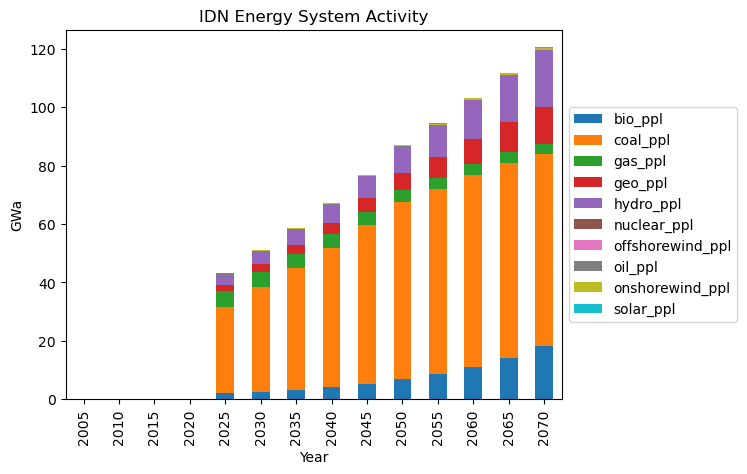

In [804]:
rep.set_filters(t=ppl_tec, ya=historical_horizon+model_horizon)
rep.get("plot activity")

<Axes: title={'center': 'IDN Energy System Capacity'}, xlabel='Year', ylabel='GW'>

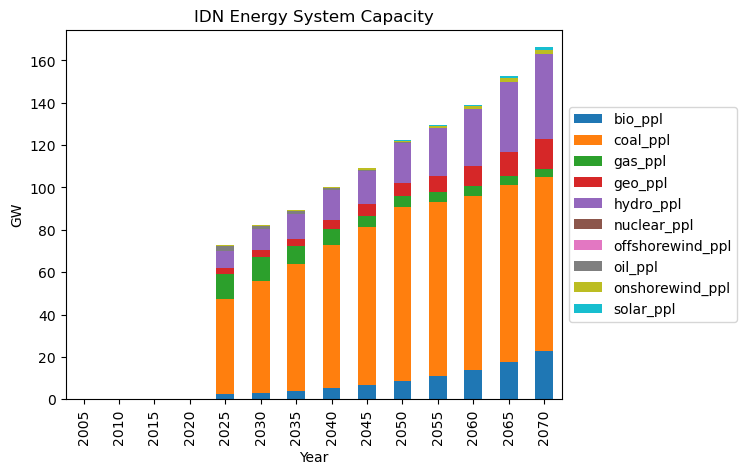

In [805]:
rep.get('plot capacity')

<Axes: title={'center': 'IDN Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

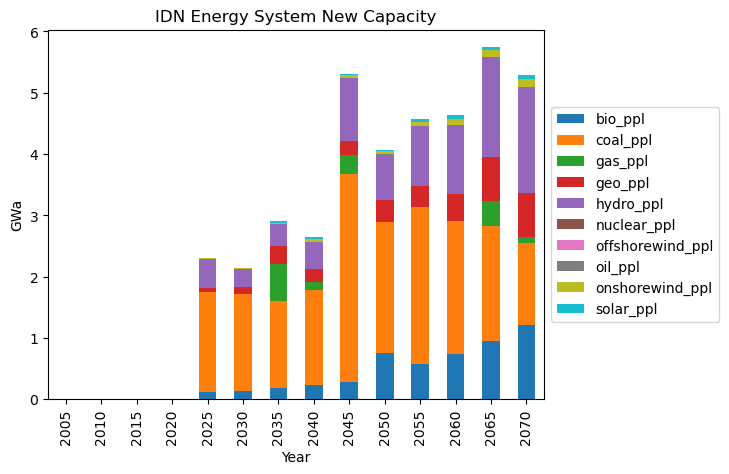

In [806]:
rep.get('plot new capacity')

<Axes: title={'center': 'IDN Fossil Supply'}, xlabel='Resource volume [GWa]', ylabel='Cost [USD / KWa]'>

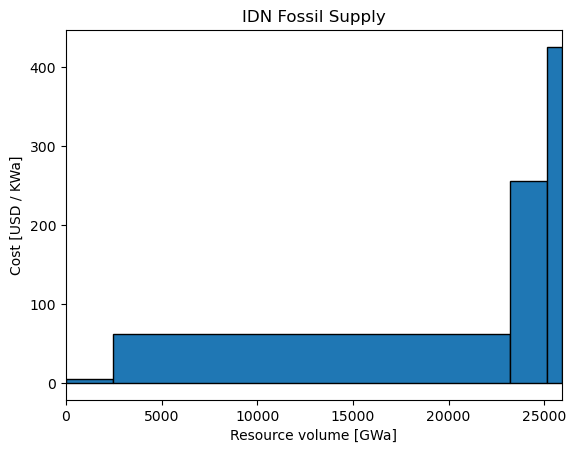

In [807]:
rep.set_filters()
rep.get("plot fossil supply curve")


<Axes: title={'center': 'g\n    IDN\nName: 0, dtype: object Energy System Extraction'}, xlabel='Year', ylabel='GW'>

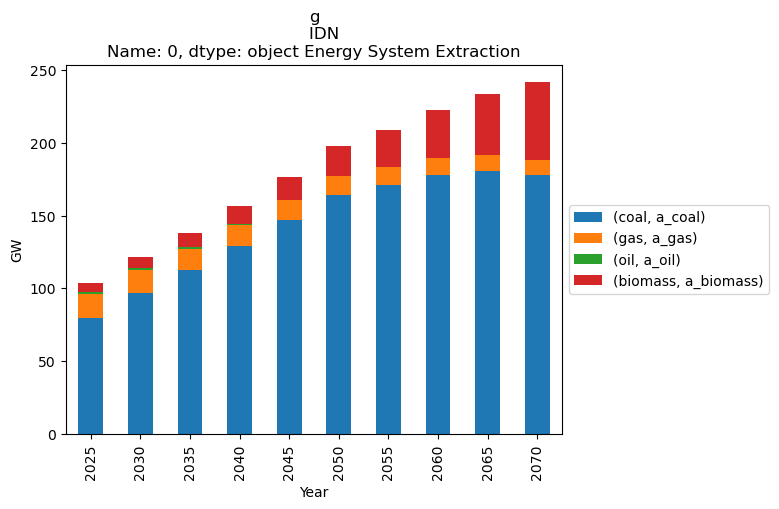

In [808]:
rep.set_filters()
rep.get("plot extraction")


<Axes: title={'center': 'IDN Energy System Demand'}, xlabel='Year', ylabel='GWa'>

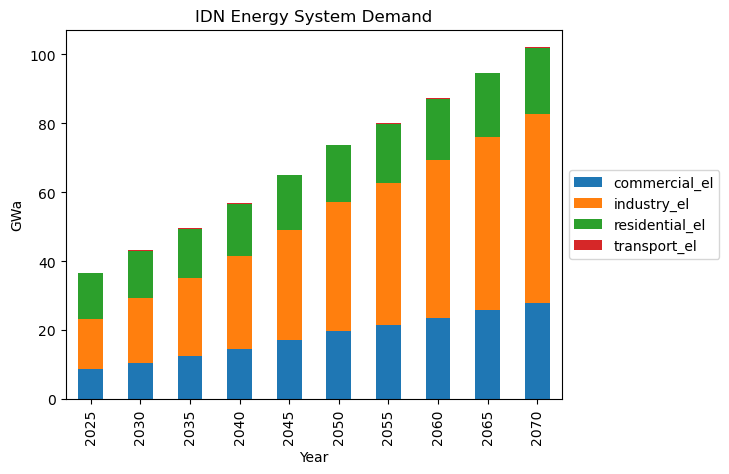

In [809]:
rep.get('plot demand')

<Axes: title={'center': 'IDN Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

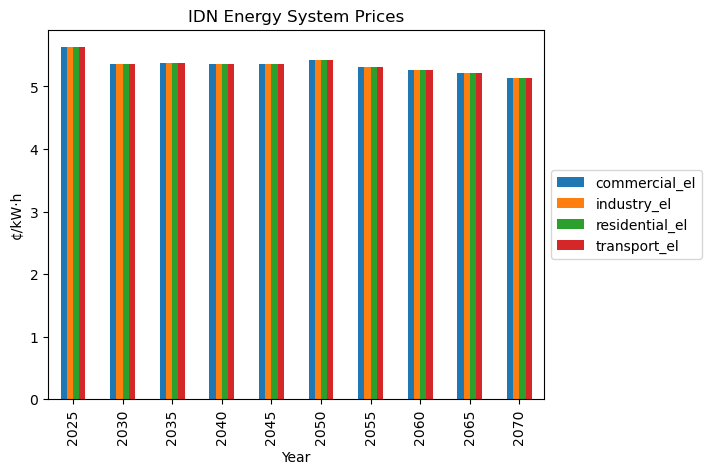

In [810]:
rep.set_filters(t=None, c=demand_com)
rep.get("plot prices")

In [884]:
scenario.remove_solution()

In [885]:
scenario.check_out()

In [887]:
mp.close_db()